# SR3

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pylops

from pyproximal.optimization.sr3 import SR3

In [ ]:
import time


def PALM(H, proxf, proxg, x0, y0, gammaf=1., gammag=1.,
         niter=10, callback=None, show=False):
    r"""Proximal Alternating Linearized Minimization

    Solves the following minimization problem using the Proximal Alternating
    Linearized Minimization (PALM) algorithm:

    .. math::

        \mathbf{x}\mathbf{,y} = \argmin_{\mathbf{x}, \mathbf{y}}
        f(\mathbf{x}) + g(\mathbf{y}) + H(\mathbf{x}, \mathbf{y})

    where :math:`f(\mathbf{x})` and :math:`g(\mathbf{y})` are any pair of
    convex functions that have known proximal operators, and
    :math:`H(\mathbf{x}, \mathbf{y})` is a smooth function.

    Parameters
    ----------
    H : :obj:`pyproximal.utils.bilinear.Bilinear`
        Bilinear function
    proxf : :obj:`pyproximal.ProxOperator`
        Proximal operator of f function
    proxg : :obj:`pyproximal.ProxOperator`
        Proximal operator of g function
    x0 : :obj:`numpy.ndarray`
        Initial x vector
    y0 : :obj:`numpy.ndarray`
        Initial y vector
    gammaf : :obj:`float`, optional
        Positive scalar weight for ``f`` function update
    gammag : :obj:`float`, optional
        Positive scalar weight for ``g`` function update
    niter : :obj:`int`, optional
        Number of iterations of iterative scheme
    callback : :obj:`callable`, optional
        Function with signature (``callback(x)``) to call after each iteration
        where ``x`` and ``y`` are the current model vectors
    show : :obj:`bool`, optional
        Display iterations log

    Returns
    -------
    x : :obj:`numpy.ndarray`
        Inverted x vector
    y : :obj:`numpy.ndarray`
        Inverted y vector

    Notes
    -----
    PALM [1]_ can be expressed by the following recursion:

    .. math::

        \mathbf{x}^{k+1} = \prox_{c_k f}(\mathbf{x}^{k} -
        \frac{1}{c_k}\nabla_x H(\mathbf{x}^{k}, \mathbf{y}^{k}))\\
        \mathbf{y}^{k+1} = \prox_{d_k g}(\mathbf{y}^{k} -
        \frac{1}{d_k}\nabla_y H(\mathbf{x}^{k+1}, \mathbf{y}^{k}))\\

    Here :math:`c_k=\gamma_f L_x` and :math:`d_k=\gamma_g L_y`, where
    :math:`L_x` and :math:`L_y` are the Lipschitz constant of :math:`\nabla_x H`
    and :math:`\nabla_y H`, respectively.

    .. [1] Bolte, J., Sabach, S., and Teboulle, M. "Proximal alternating
       linearized minimization for nonconvex and nonsmooth problems",
       Mathematical Programming, vol. 146, pp. 459–494. 2014.

    """
    if show:
        tstart = time.time()
        print('PALM algorithm\n'
              '---------------------------------------------------------\n'
              'Bilinear operator: %s\n'
              'Proximal operator (f): %s\n'
              'Proximal operator (g): %s\n'
              'gammaf = %10e\tgammaf = %10e\tniter = %d\n' %
              (type(H), type(proxf), type(proxg), gammaf, gammag, niter))
        head = '   Itn      x[0]       y[0]        f         g         H         ck         dk'
        print(head)

    x, y = x0.copy(), y0.copy()
    for iiter in range(niter):
        ck = gammaf * H.ly(y)
        x = x - (1 / ck) * H.gradx(x.ravel())
        if proxf is not None:
            x = proxf.prox(x, ck)
        H.updatex(x.copy())
        dk = gammag * H.lx(x)
        y = y - (1 / dk) * H.grady(y.ravel())
        if proxg is not None:
            y = proxg.prox(y, dk)
        H.updatey(y.copy())

        # run callback
        if callback is not None:
            callback(x, y)

        if show:
            pf = proxf(x) if proxf is not None else 0.
            pg = proxg(y) if proxg is not None else 0.
            if iiter < 10 or niter - iiter < 10 or iiter % (niter // 10) == 0:
                msg = '%6g  %5.5e  %5.2e  %5.2e  %5.2e  %5.2e  %5.2e  %5.2e' % \
                      (iiter + 1, x[0], y[0], pf if pf is not None else 0.,
                       pg if pg is not None else 0., H(x, y), ck, dk)
                print(msg)
    if show:
        print('\nTotal time (s) = %.2f' % (time.time() - tstart))
        print('---------------------------------------------------------\n')
    return x, y

In [2]:
# As a test case, I implemented the gravity example
def gravity(n):
    # GRAVITY Test problem: 1-D gravity surveying model problem
    #
    # [A,b,x] = gravity(n,example,a,b,d)
    #
    # Discretization of a 1-D model problem in gravity surveying, in which
    # a mass distribution f(t) is located at depth d, while the vertical
    # component of the gravity field g(s) is measured at the surface.
    #
    # The resulting problem is a first-kind Fredholm integral equation
    # with kernel
    #    K(s,t) = d*(d^2 + (s-t)^2)^(-3/2) .
    # The following three examples are implemented (example = 1 is default):
    #    1: f(t) = sin(pi*t) + 0.5*sin(2*pi*t),
    #    2: f(t) = piecewise linear function,
    #    3: f(t) = piecewise constant function.
    # The problem is discretized by means of the midpoint quadrature rule
    # with n points, leading to the matrix A and the vector x.  Then the
    # right-hand side is computed as b = A*x.
    #
    # The t integration interval is fixed to [0,1], while the s integration
    # interval [a,b] can be specified by the user. The default interval is
    # [0,1], leading to a symmetric Toeplitz matrix.
    #
    # The parameter d is the depth at which the magnetic deposit is located,
    # and the default value is d = 0.25. The larger the d, the faster the
    # decay of the singular values.

    # Reference: G. M. Wing and J. D. Zahrt, "A Primer on Integral Equations
    # of the First Kind", SIAM, Philadelphia, 1991; p. 17.

    # Per Christian Hansen, IMM, November 18, 2001.

    # Initialization.
    a = 0
    b = 1
    d = 0.25

    # Set up abscissas and matrix.
    dt = 1/n
    ds = (b-a)/n
    t = dt*(np.linspace(1, n, n) - 0.5)
    s = a + ds*(np.linspace(1, n, n) - 0.5)
    T, S = np.meshgrid(t, s)
    A = dt*d*np.ones((n, n))/(d**2 + (S-T)**2)**(3/2)

    # Set up solution vector and right-hand side.
    # nt = int(np.round(n/3))
    # nn = np.round(n*7/8)
    # x = np.zeros((n, 1))
    # x[0:nt] = 2*np.ones((nt, 1))
    x = np.heaviside(t - 0.2, 1) + 2.1*np.heaviside(t - 0.4, 1) - 1.2*np.heaviside(t - 0.7, 1)
    x = x
    b = np.dot(A, x)

    return A, b, x

In [3]:
n = 64
A, b, x = gravity(n)
#L = np.diag(-np.ones(n), 0) + np.diag(np.ones(n-1), 1)
#L = L[:len(x)-1][:]
#Lop = pylops.MatrixMult(L)

Aop = pylops.MatrixMult(A)
Lop = pylops.FirstDerivative(n, kind='forward')

Relative error for SR3: 0.00165643624974003


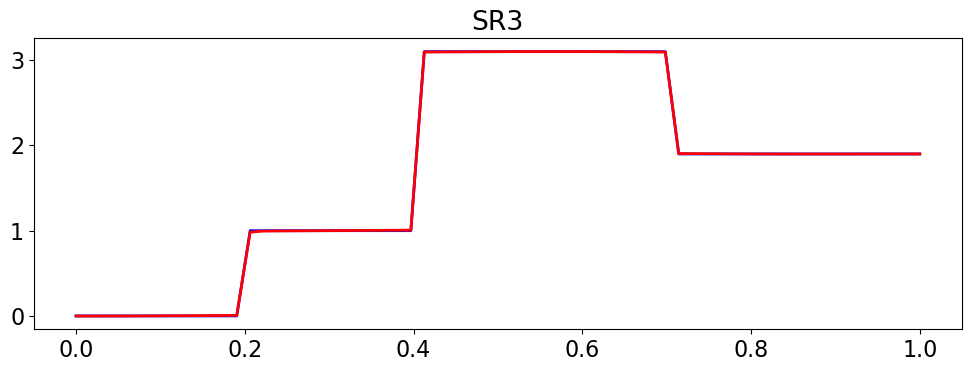

In [4]:
x_sr3 = SR3(Aop, Lop, b, 1, 1e-3, iter_lim_outer=int(1e4), adaptive=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
x_plot = np.linspace(0, 1, n)
ax.plot(x_plot, x, color='b', linewidth=2)
ax.plot(x_plot, x_sr3, color='r', linewidth=2)
ax.set_title('SR3')
ax.axis('tight')
fig.tight_layout()

print('Relative error for SR3:', np.linalg.norm(x - x_sr3)/(np.linalg.norm(x)))

Relative error for SR3: 0.0014959625661228998


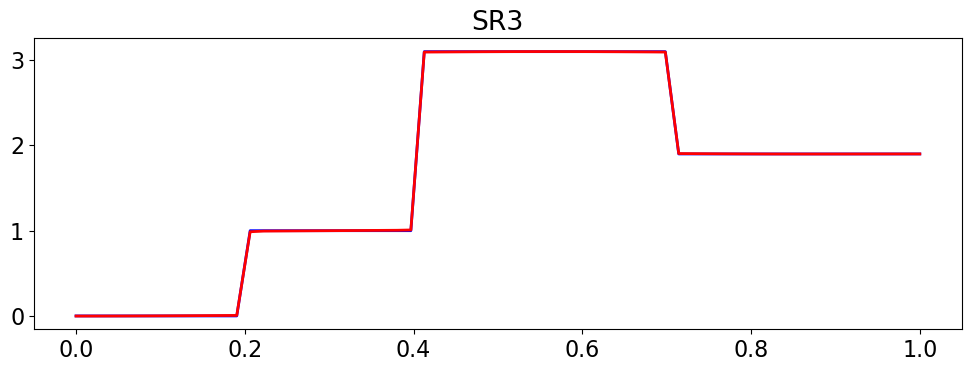

In [5]:
x_sr3 = SR3(Aop, Lop, b, 1, 1e-3, iter_lim_outer=int(1e4), adaptive=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
x_plot = np.linspace(0, 1, n)
ax.plot(x_plot, x, color='b', linewidth=2)
ax.plot(x_plot, x_sr3, color='r', linewidth=2)
ax.set_title('SR3')
ax.axis('tight')
fig.tight_layout()

print('Relative error for SR3:', np.linalg.norm(x - x_sr3)/(np.linalg.norm(x)))